In [4]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import fenics as fe
import torch
import torch.nn.functional as F
import torch_fenics

import sys
sys.path.append('..')
import project

In [6]:
%autoreload
case = project.imaging.Emory4DCT('../data/Emory-4DCT')[0]
case.load_niftis()
case.load_masks(roi='lung_regions')
case.load_displacements(moving_phase=10, relative=True)
case.load_meshes(roi='lung_regions', mesh_radius=10)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T40/lung_regions.nii.gz


In [7]:
case.anat

<xarray.DataArray 'CT' (phase: 10, x: 256, y: 256, z: 94)> Size: 493MB
array([[[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -626.,  -632.,  -680., ...,  -716.,  -664.,  -796.],
         [ -545.,  -551.,  -562., ...,  -388.,  -458.,  -494.],
         [ -399.,  -405.,  -384., ...,  -381.,  -347.,  -422.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -616.,  -624.,  -670., ...,  -724.,  -672.,  -809.],
         [ -548.,  -533.,  -547., ...,  -380.,  -452.,  -499.],
         [ -402.,  -398.,  -367., ...,  -375.,  -353.,  -414.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
...
         ...,
         [ -597.,  -584.,  -593., ...,  -518.,  -488.,  -539.],
         [ -367.,  -379.,  -408., ...,  -376.,  -424.,  -419.],
         [ -420.,  -408.,  -417., ...,  -689.,  -695.,  -691.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -584.,  -564.,  -590., ...,  -534.,  -493.,  -540.],
         [ -368.,  -374.,  -393., ...,  -377.,  -422.,  -424.],
         [ -408.,  -393.,  -410., ...,  -688.,  -696.,  -702.]],

        [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
         ...,
         [ -593.,  -593.,  -585., ...,  -536.,  -505.,  -539.],
         [ -391.,  -379.,  -385., ...,  -389.,  -445.,  -401.],
         [ -409.,  -410.,  -414., ...,  -695.,  -697.,  -689.]]]])
Coordinates:
  * phase    (phase) int64 80B 0 10 20 30 40 50 60 70 80 90
  * x        (x) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * y        (y) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.4
  * z        (z) float64 752B 0.0 2.5 5.0 7.5 10.0 ... 225.0 227.5 230.0 232.5

CT


<IPython.core.display.Javascript object>


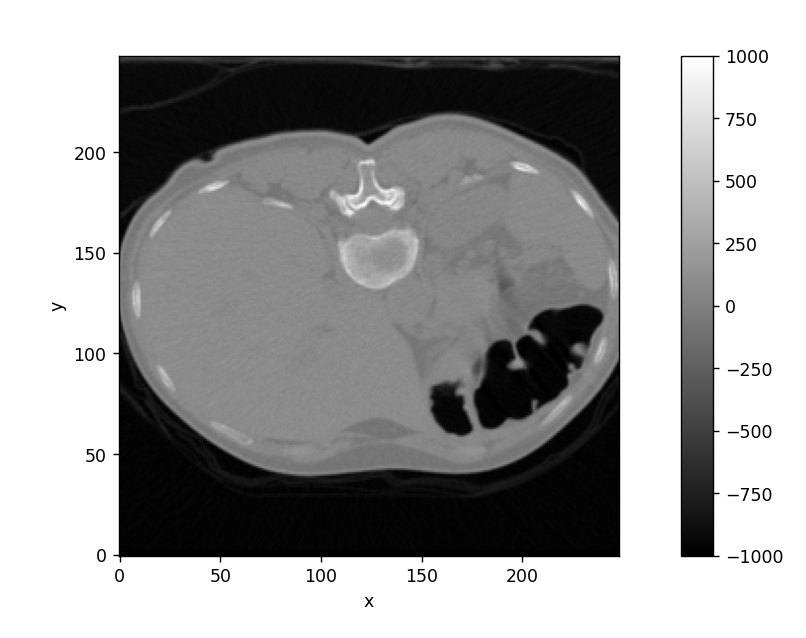

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

torch.Size([1, 256, 256, 94])


In [8]:
project.visual.XArrayViewer(case.anat)

anat_image = torch.as_tensor(case.anat.sel(phase=0).values).unsqueeze(0)
print(anat_image.shape)

In [11]:
mesh = case.meshes[0]
mesh

In [10]:
print('\n'*5)

In [20]:
S = fe.FunctionSpace(mesh, 'P', 1)

points = torch.as_tensor(S.tabulate_dof_coordinates())
points.shape

torch.Size([17594, 3])

In [21]:
%%time

def compute_point_radius(points, resolution):
    min_radius = np.linalg.norm(resolution) / 2
    distance = torch.norm(points[:,None,:] - points[None,:,:], dim=-1)
    distance[distance == 0] = 1e3
    distance[distance < min_radius] = min_radius
    return distance.min(dim=-1, keepdims=True).values

radius = compute_point_radius(points, case.resolution)

CPU times: user 12.3 s, sys: 3.41 s, total: 15.7 s
Wall time: 496 ms


In [27]:
kernel_size = (radius / torch.as_tensor(case.resolution)).floor().long().max()
kernel_size

tensor(12)

In [36]:
%%time

def interpolate_image(image, resolution, points, kernel_radius, kernel_size=None):
    '''
    Image interpolation method that takes a weighted sum
    of the image values in the neighborhood of each point.

    Args:
        image: (C, X, Y, Z) image tensor
        resolution: image resolution (float)
        points: (N, 3) sampling points
        kernel_radius: kernel shape parameter (N,)
        kernel_size: kernel neighborhood size (int)
    '''
    C, X, Y, Z = image.shape
    N, D = points.shape
    assert D == 3, 'points must be 3D'
    
    zeros = torch.zeros(D, device=image.device)
    shape = torch.as_tensor([X, Y, Z], device=image.device)
    resolution = torch.as_tensor(resolution, device=image.device) 
  
    if kernel_size is None:
        kernel_size = (radius / resolution).floor().long().max()
    x_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    y_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    z_offsets = torch.arange(-kernel_size, kernel_size, device=image.device) + 1
    
    offsets = torch.meshgrid(x_offsets, y_offsets, z_offsets, indexing='ij')
    offsets = torch.stack(offsets, dim=-1).reshape(-1, D) # (K, D)

    nearest_voxel = (points / resolution.unsqueeze(0)).floor().long() # (N, D)
    
    neighbor_voxels = nearest_voxel.unsqueeze(1) + offsets.unsqueeze(0) # (N, K, D)
    neighbor_voxels = neighbor_voxels.clamp(min=zeros, max=(shape - 1)).long()
    
    neighbor_values = image[
        :,
        neighbor_voxels[:,:,0],
        neighbor_voxels[:,:,1],
        neighbor_voxels[:,:,2],
    ].permute(1,2,0) # (N, K, C)
    
    neighbor_points = neighbor_voxels * resolution.unsqueeze(0).unsqueeze(0) # (N, K, D)
    
    displacement = (neighbor_points - points.unsqueeze(1)) # (N, K, D)
    distance = torch.norm(displacement, dim=-1) # (N, K)
    
    weights = torch.clamp(1 - torch.abs(distance / kernel_radius), 0) # (N, K)
    weights = (distance <= kernel_radius).float()
    
    weighted_sum = (weights.unsqueeze(-1) * neighbor_values).sum(dim=1) # (N, C)
    total_weight = weights.sum(dim=-1, keepdims=True) # (N, 1)
    
    interpolated_values = weighted_sum / total_weight # (N, C)

    return interpolated_values

anat_dofs = interpolate_image(anat_image, case.resolution, points, radius)
anat_dofs.mean()

CPU times: user 40.1 s, sys: 23 s, total: 1min 3s
Wall time: 1.99 s


tensor(-495.8033, dtype=torch.float64)

In [40]:
%%time

def image_to_dofs(image, resolution, V, kernel_radius, kernel_size=None):
    '''
    Args:
        image: (C, X, Y, Z) torch.Tensor
        V: fenics.FunctionSpace
            defined on (N, D) coordinates
    Returns:
        dofs: (N, C) torch.Tensor
    '''
    C, X, Y, Z = image.shape
    
    points = V.tabulate_dof_coordinates()
    if V.num_sub_spaces() > 0:
        points = points[::V.num_sub_spaces(),:]
    
    N, D = points.shape

    points = torch.as_tensor(points, dtype=image.dtype, device=image.device)

    values = interpolate_image(
        image=image,
        points=points,
        resolution=resolution,
        kernel_radius=kernel_radius,
        kernel_size=kernel_size,
    ).double()

    if V.num_sub_spaces() > 0:
        return values.view(N, C)
    else:
        return values.view(N)
    
anat_image = torch.as_tensor(case.anat.sel(phase=0).values).unsqueeze(0)
anat_image.requires_grad = True
print(anat_image.shape)

V = fe.FunctionSpace(mesh, 'P', 1)
anat_dofs = image_to_dofs(
    anat_image,
    case.resolution,
    V,
    kernel_radius=radius
)
print(anat_dofs.shape)

L = anat_dofs.sum()
L.backward()

torch.Size([1, 256, 256, 94])
torch.Size([17594])
CPU times: user 48.3 s, sys: 31.4 s, total: 1min 19s
Wall time: 4.46 s


In [41]:
%%time

def dofs_to_image(dofs, V, image_shape, resolution):
    '''
    Args:
        dofs: (N, C) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
        image_shape: (int, int, int) tuple
    Returns:
        image: (C, X, Y, Z) torch.Tensor
    '''
    if V.num_sub_spaces() > 0:
        N, C = dofs.shape
    else:
        N, = dofs.shape
        C = 1

    X, Y, Z = image_shape

    x = np.arange(X) * resolution[0]
    y = np.arange(Y) * resolution[1]
    z = np.arange(Z) * resolution[2]

    grid = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)

    func = torch_fenics.numpy_fenics.numpy_to_fenics(
        dofs.detach().cpu().numpy(), fe.Function(V)
    )
    func.set_allow_extrapolation(True)

    image = np.zeros((X, Y, Z, C))
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                func.eval(image[i,j,k], grid[i,j,k])

    if V.num_sub_spaces() == 0:
        return torch.as_tensor(image).permute(3,0,1,2)
    else:
        return torch.as_tensor(image).permute(3,0,1,2)

print(anat_dofs.shape)
anat_interp = dofs_to_image(anat_dofs, V, case.shape, case.resolution)
anat_interp.shape

torch.Size([17594])
CPU times: user 2min 40s, sys: 88.7 ms, total: 2min 40s
Wall time: 2min 42s


torch.Size([1, 256, 256, 94])

In [ ]:
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_image, dims=['c', 'x', 'y', 'z'], name='anat_image')                         
)
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_interp, dims=['c', 'x', 'y', 'z'], name='anat_interp')                         
)
project.visual.XArrayViewer(
    project.utils.as_xarray(anat_image.grad, dims=['c', 'x', 'y', 'z'], name='grad'), cmap='seismic'                         
)